In [1]:
suppressMessages(library(scran))
library(BiocParallel)
suppressMessages(library(limma))
suppressMessages(library(EnhancedVolcano))
library(patchwork)
suppressMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(clusterProfiler))
suppressPackageStartupMessages(library("org.Hs.eg.db"))
suppressMessages(library(ggsci))
suppressMessages(library(scran))
library(muscat)

In [12]:
getvolcone_mast=function(res_table, pcutoff=0.01,FCcutoff=0.5, selectLab=NULL, connector=F, title=NULL, exhaust=F){
if (exhaust==T){
    selectLab=c('PDCD1', 'CTLA4', 'LAG3', 'HAVCR2', 'CD244', 'CD160', 'TIGIT') 
}else{selectLab=selectLab }
p=EnhancedVolcano(res_table,
                  lab = rownames(res_table),                  
                  x = 'avg_log2FC',
                  y = 'p_val_adj',
                  ylab='-log10(p.adj)',
                  title=title,
               subtitle =NULL,
                pCutoff = pcutoff,
                FCcutoff = FCcutoff,
                 legendPosition = 'none',
                 ylim = c(0, max(max(-log10(res_table$p_val_adj), na.rm = TRUE) + 1, -log10(0.05)+1)),
                 caption=NULL,
                 pointSize = 0.5, 
                   drawConnectors = connector,
                  labSize=5,
                 selectLab=selectLab,
                  max.overlaps=20
                 )    
    }

In [5]:
plotcnet_mast=function(res_table, direction, pcutoff=0.01, wraplength=30, title=NULL){


    if (direction=='up'){
genelist=res_table %>% filter(p_val_adj<pcutoff, avg_log2FC>0.5) %>% rownames(res_table)
        title='upregulated'
        } else {
        genelist=res_table %>% filter(p_val_adj<pcutoff, avg_log2FC< -0.5) %>% rownames(res_table)
        title='downregulated'
    }

    if (length(genelist)<4){
        return(list(NULL, NULL))
    }

geneset <- enrichGO(gene   = genelist,
                    OrgDb         = org.Hs.eg.db,
                    keyType       = 'ALIAS',
                    ont           = "BP",
                    pAdjustMethod = "BH",
                    universe=rownames(res_table))

if (nrow(geneset)==0){
    return(list(geneset, NULL))
}
    
    genefc=res_table[geneset@gene,'avg_log2FC']
    names(genefc)=geneset@gene
    
  
#bp <- simplify(geneset, cutoff=0.7, by="p.adjust", select_fun=min)
#p2 <- cnetplot(geneset, categorySize="pvalue")+ggtitle(cluster_id)
    p2=heatplot(geneset, foldChange =genefc, showCategory=10,label_format =wraplength)+ggtitle(title)
    return(list(geneset, p2))
}

In [5]:
seuratobj_full=readRDS('/mnt/MXMERZ002A/LargeData/seuratobj_1.rds')

In [6]:
fullADT=seuratobj_full[['ADT']]

In [7]:
#Preprocess seuratobj_full
seuratobj_full=DietSeurat(
  seuratobj_full,
  counts = TRUE,
  data = T,
  scale.data = FALSE,
  features = NULL,
  assays = c('RNA', 'ADT'),
  dimreducs = F,
  graphs = F
)
#seuratobj_full <- NormalizeData(seuratobj_full, normalization.method = "CLR", margin = 2, assay = "ADT")
seuratobj_full@meta.data=seuratobj_full@meta.data %>% 
mutate(timepoint=ifelse(days.since.apharesis<2, 'apharesis','post_infusion')) %>%
unite(orig.ident.WNN_l2, orig.ident, WNN_l2, remove=F) 

seuratobj_full$ciltacabtagene_pos=ifelse(GetAssayData(seuratobj_full, slot='counts', assay = 'RNA')['ciltacabtagene',]>0,
                                        'Ciltapos',
                                         'Ciltaneg')

seuratobj_full$idecabtagene_pos=ifelse(GetAssayData(seuratobj_full, slot='counts', assay = 'RNA')['idecabtagene',]>0,
                                        'Idepos',
                                         'Ideneg')

genenames=rownames(seuratobj_full)

IGHVgenes=genenames[grep('^IGHV', genenames)]
IGLVgenes=genenames[grep('^IGK|^IGL', genenames)]
TRgenes=genenames[grep('^TR(B|A)V', genenames)]

sexgenes=c('XIST', 'RPS4Y1', 'RPS4Y2')

informative_genes=setdiff(genenames, Reduce(union, list(IGHVgenes, IGLVgenes, TRgenes, sexgenes)))

seuratobj_full@meta.data=seuratobj_full@meta.data %>% mutate(Tcells=ifelse(grepl('T cells$', WNN_agg), 'Tcells', 'Others')) %>%
unite(condition, orig.ident, Tcells, ciltacabtagene_pos, remove=F)

In [8]:
seuratobj_full=seuratobj_full[informative_genes, ] 
seuratobj_full[['ADT']]=fullADT

In [9]:
seuratobj_full <- NormalizeData(seuratobj_full, normalization.method = "CLR", margin = 2, assay = "ADT")

Normalizing across cells



In [10]:
#Prepare ADT data
mmtargets_exp=GetAssayData(seuratobj_full, slot='data', assay='ADT')
mmtargets_exp=t(as.matrix(mmtargets_exp))
mmtargets_exp=cbind(mmtargets_exp, seuratobj_full@meta.data %>% dplyr::select(condition, WNN_agg))
mmtargets_exp=mmtargets_exp  %>% pivot_longer(cols=!c(condition,WNN_agg), names_to='ADT', values_to='expression')

## Patient 12 Ide-cel CART cells

### Post infusion CAR T vs premanufacture T cells in PBMC
Here we compared P12_84\_28\_PB CART cells to P12\_-1\_-57_PB T cells. 

In [10]:
options(mc.cores=1)
res_CARvspre=FindMarkers(seuratobj_full, ident.1='P12_84_28_PB_Tcells_TRUE', ident.2='P12_-1_-57_PB_Tcells_FALSE', group.by='condition', logfc.threshold=0,
                         test.use='MAST', latent.vars = 'WNN_agg')


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



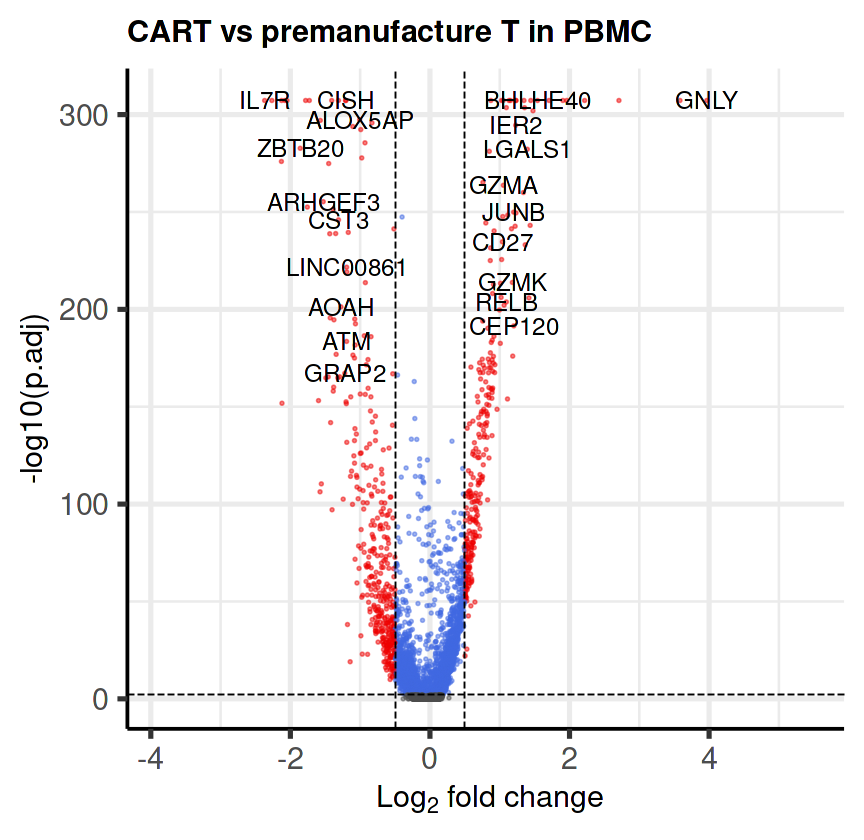

In [14]:
# Figure 7A
options(warn = -1)
res_CARvspre=res_CARvspre %>% mutate(p_val_adj=ifelse(p_val_adj==0, min( p_val_adj[p_val_adj!=min(p_val_adj)] ), p_val_adj))
negsig=res_CARvspre %>% filter(avg_log2FC< -1) %>% slice_min(p_val_adj, n=40) %>% rownames
possig=res_CARvspre %>% filter(avg_log2FC> 1) %>% slice_min(p_val_adj, n=40) %>% rownames
selectLab=c(negsig, possig)
p1=getvolcone_mast(res_CARvspre, title='CART vs premanufacture T in PBMC', connector = F, selectLab=selectLab)
#p2=getvolcone_mast(res_CARvspre, title='CART vs premanufacture T in PBMC \n(Exhaustion markers))', connector = T, exhaust=T)
options(repr.plot.width=7.2, repr.plot.height=7)
p1
options(warn = 0)

In [23]:
res_CARvspre %>% rownames_to_column('genes') %>% write_csv('3.PostvsPre.csv')

Results saved in 3.PostvsPre.csv

In [31]:
go_CARvspre_up=plotcnet_mast(res_CARvspre, direction='up')
go_CARvspre_down=plotcnet_mast(res_CARvspre, direction='down')

### Enriched biological processes for upregulated and downregulated genes
Upregulated means more highly expressed in CAR T vs premanufacture T. Only the top ten pathways in terms of p value are shown. 

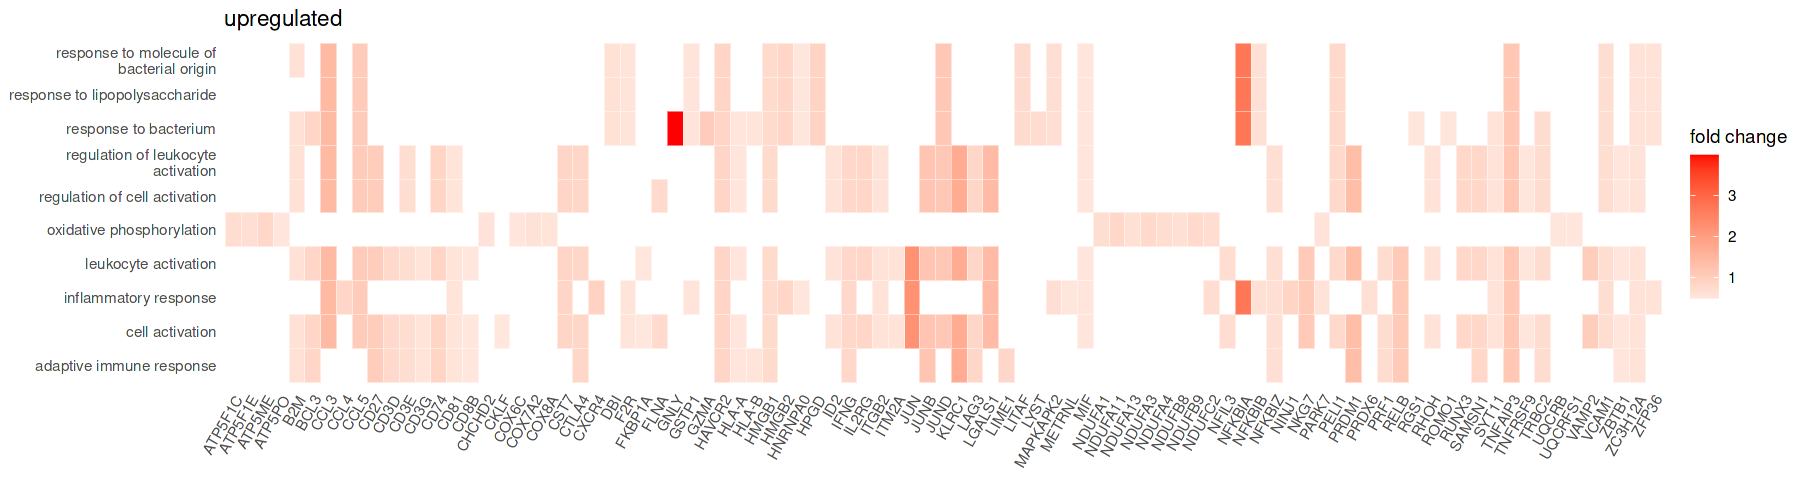

In [32]:
# Supp figure 3
options(repr.plot.width=15, repr.plot.height=4)
go_CARvspre_up[[2]]

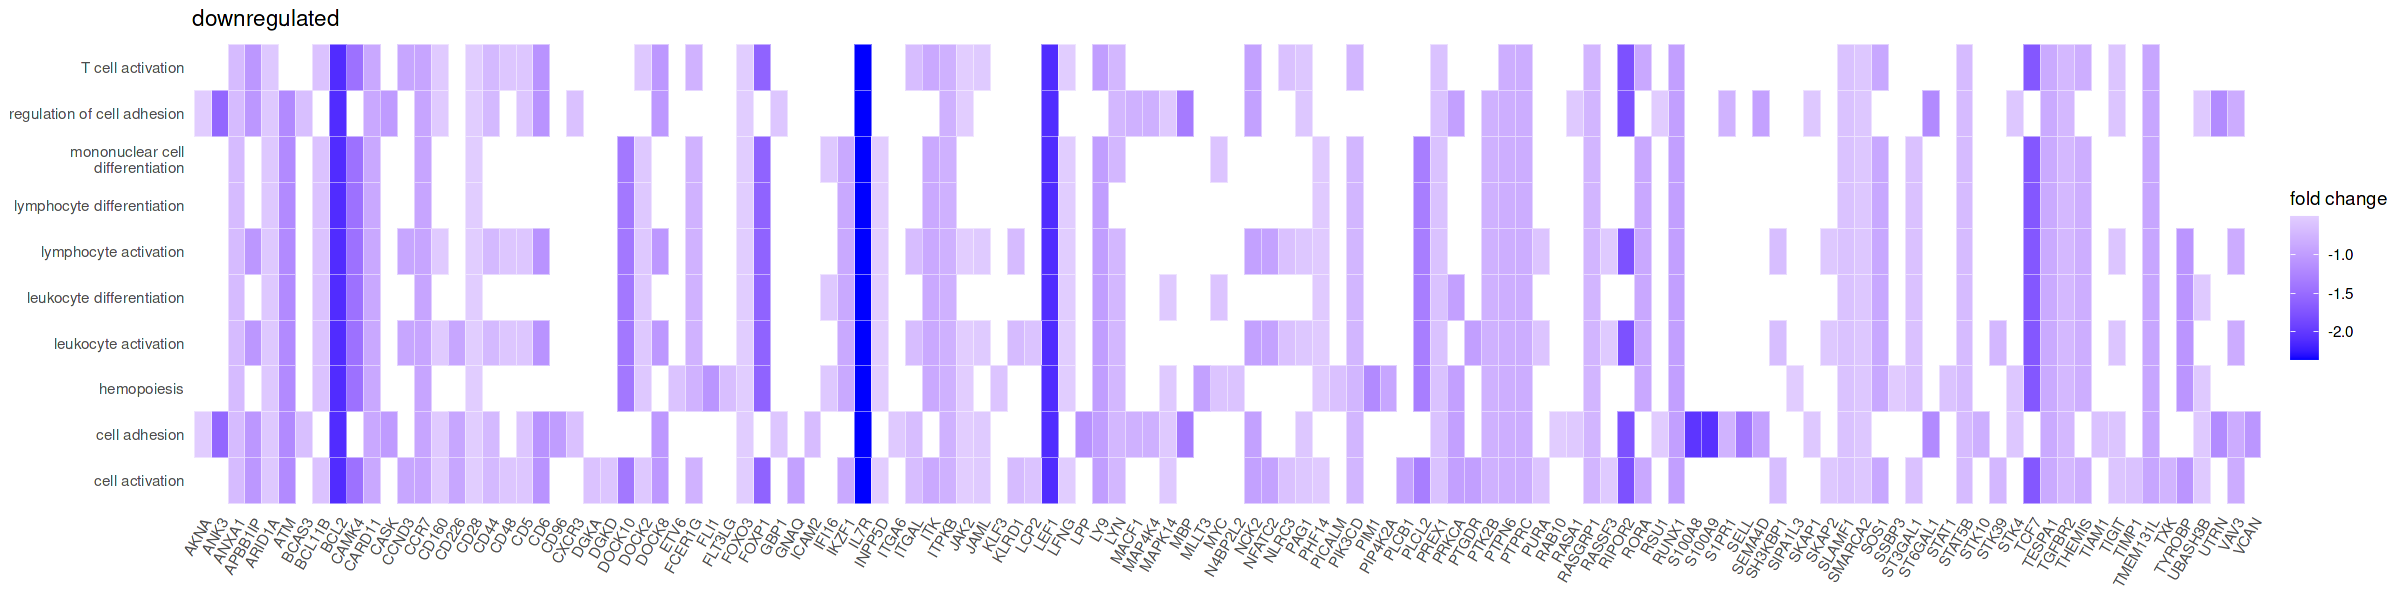

In [33]:
# Supp figure 3
options(repr.plot.width=20, repr.plot.height=5)
go_CARvspre_down[[2]]

In [20]:
#ADT
res_CARvspre_ADT=FindMarkers(seuratobj_full, ident.1='P12_84_28_PB_Tcells_TRUE', ident.2='P12_-1_-57_PB_Tcells_FALSE', group.by='condition', features=adttotest, logfc.threshold=0, assay='ADT')

In [21]:
adttoplot=res_CARvspre_ADT%>% filter(p_val_adj<0.05) %>% arrange(p_val_adj, -abs(avg_log2FC))  %>% slice_head(n=10) %>% rownames
mmtargets_plot=mmtargets_exp %>% filter(condition %in% c('P12_84_28_PB_Tcells_TRUE','P12_-1_-57_PB_Tcells_FALSE'), ADT %in% adttoplot)
mmtargets_plot$ADT=factor(mmtargets_plot$ADT, levels=str_sort(unique(mmtargets_plot$ADT), numeric=T))

In [22]:
mmtargets_plot=mmtargets_plot %>% mutate(condition=ifelse(condition=='P12_84_28_PB_Tcells_TRUE','CAR','Premanufacture'))

ADTs that are differentially expressed. Only the top ten in terms of p value followed by logFC are shown.
Higher CD45RA expression indicates more naive phenotype in premanufacture T cells. Higher CD69 indicates more activation in premanufacture T cells. Higher CD279 in CAR indicates more exhaustion in CAR T. 

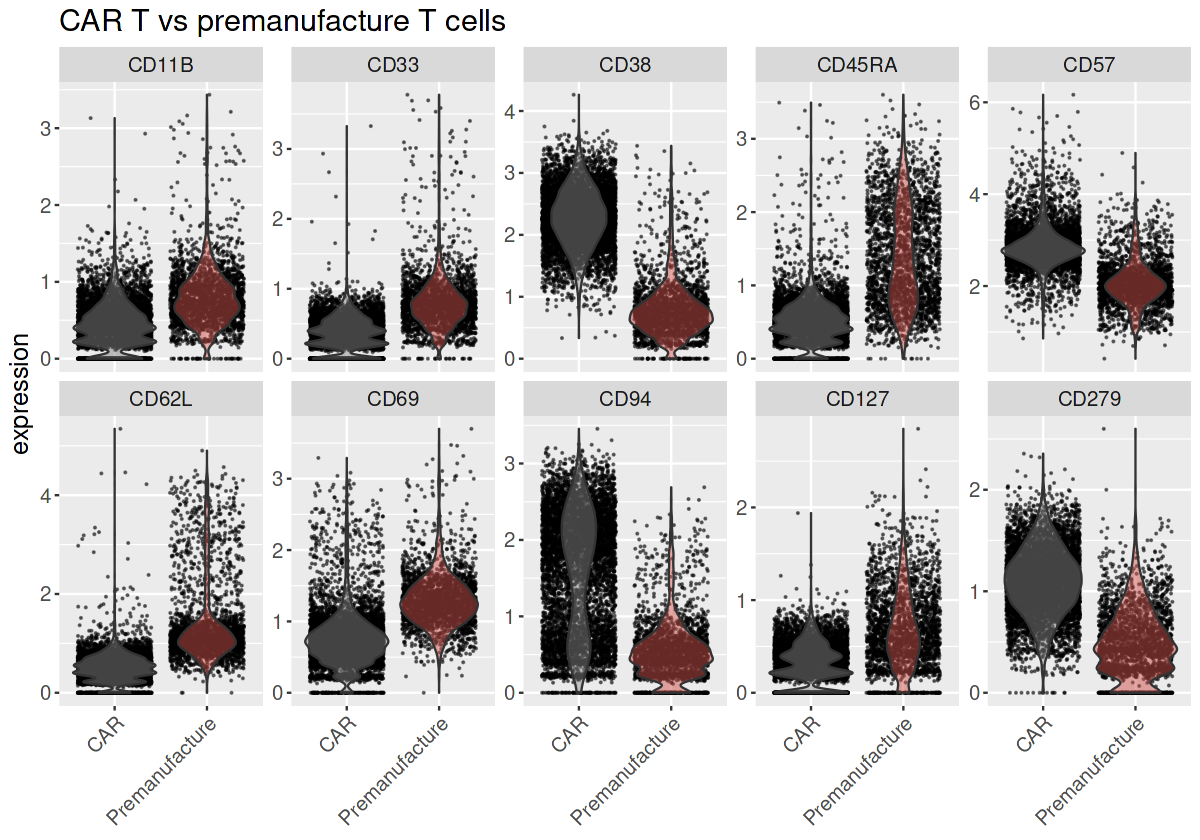

In [23]:
# Figure 7D
options(repr.plot.width=10, repr.plot.height=7)
ggplot(mmtargets_plot, aes(fill=condition, y=expression, x=condition))+geom_jitter(size=0.1, alpha=0.5)+geom_violin(alpha=0.5)+
facet_wrap(~ADT, ncol=5, scales="free_y")+ theme(legend.position = "none")+
ggtitle('CAR T vs premanufacture T cells')+
 theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+ theme(text = element_text(size = 15), axis.title.x=element_blank()) +
scale_fill_manual(values = pal_jco(palette = c("default"), alpha = 1)(n=4)[3:4])

### CAR T cells in BM vs CAR T in PBMC
Here we compare CARTs from P12_119\_63\_BM to P12_84_28_PB. 

In [15]:
#ADT
res_CARBMvsPB_ADT=FindMarkers(seuratobj_full, ident.1='P12_119_63_BM_Tcells_TRUE', ident.2='P12_84_28_PB_Tcells_TRUE', group.by='condition', logfc.threshold=0,
                         assay='ADT')

In [16]:
adttoplot=res_CARBMvsPB_ADT%>% filter(p_val_adj<0.05) %>% arrange(p_val_adj, -abs(avg_log2FC))  %>% slice_head(n=10) %>% rownames
mmtargets_plot=mmtargets_exp %>% filter(condition %in% c('P12_119_63_BM_Tcells_TRUE','P12_84_28_PB_Tcells_TRUE'), ADT %in% adttoplot)
mmtargets_plot$ADT=factor(mmtargets_plot$ADT, levels=str_sort(unique(mmtargets_plot$ADT), numeric=T))

In [17]:
mmtargets_plot=mmtargets_plot %>% mutate(condition=ifelse(condition=='P12_119_63_BM_Tcells_TRUE','BM','PB'))

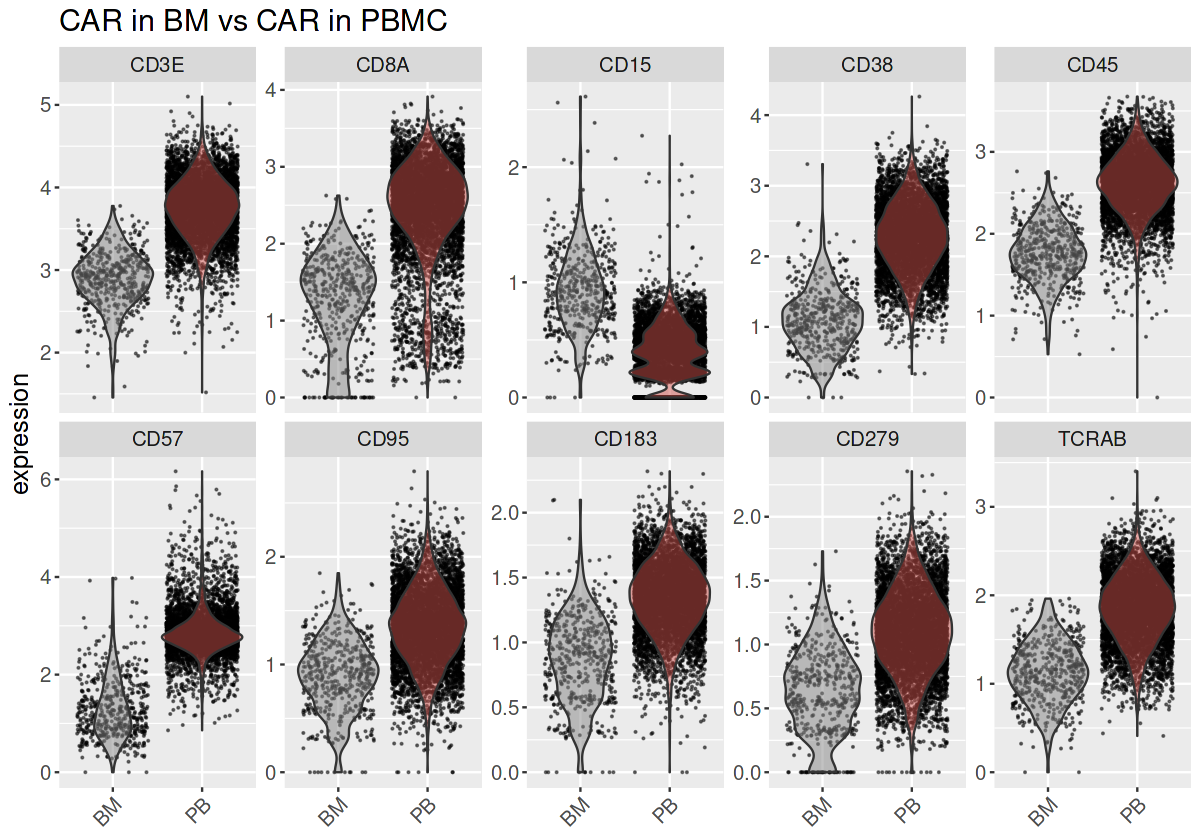

In [19]:
# Figure 7G
options(repr.plot.width=10, repr.plot.height=7)
ggplot(mmtargets_plot, aes(fill=condition, y=expression, x=condition))+geom_jitter(size=0.1, alpha=0.5)+geom_violin(alpha=0.5)+
facet_wrap(~ADT, ncol=5, scales="free_y")+ theme(legend.position = "none")+
ggtitle('CAR in BM vs CAR in PBMC')+
 theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+ 
  theme(text = element_text(size = 15), axis.title.x=element_blank()) +
scale_fill_manual(values = pal_jco(palette = c("default"), alpha = 1)(n=4)[3:4])

## Patient 14 Ide-cel CAR T cells

## Post infusion CAR T vs premanufacture T cells
Here we compared P14_85\_30\_PB CART cells to P14\_-1\_-56_PB T cells. 

In [8]:
options(mc.cores=1)
res_CARvspre=FindMarkers(seuratobj_full, ident.1='P14_85_30_PB_Tcells_TRUE', ident.2='P14_-1_-56_PB_Tcells_FALSE', group.by='condition', logfc.threshold=0,
                         test.use='MAST', latent.vars = 'WNN_agg')


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



Idecabtagene is differentially expressed but not plotted.

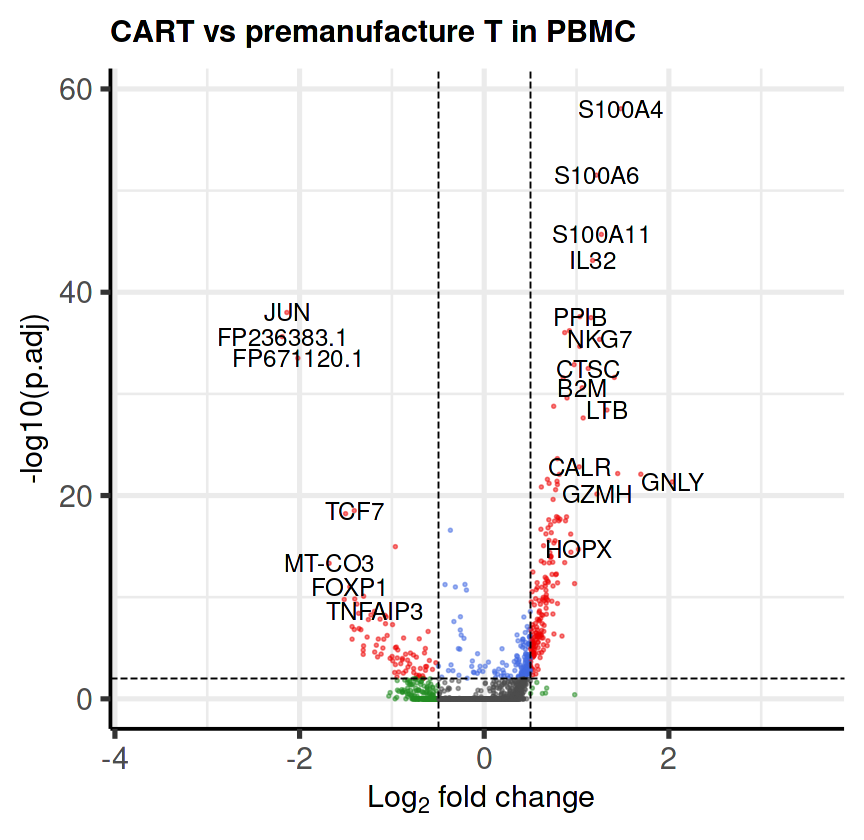

In [32]:
# Fig 7B
options(warn = -1)
res_CARvspre=res_CARvspre %>% mutate(p_val_adj=ifelse(p_val_adj==0, min( p_val_adj[p_val_adj!=min(p_val_adj)] ), p_val_adj))
negsig=res_CARvspre %>% filter(avg_log2FC< -1) %>% slice_min(p_val_adj, n=20) %>% rownames
possig=res_CARvspre %>% filter(avg_log2FC> 1) %>% slice_min(p_val_adj, n=20) %>% rownames
selectLab=c(negsig, possig)
p1=getvolcone_mast(res_CARvspre %>% filter(rownames(.) !='idecabtagene'), title='CART vs premanufacture T in PBMC', connector = F,selectLab=selectLab)
#p2=getvolcone_mast(res_CARvspre %>% filter(rownames(.) !='idecabtagene'), title='CART vs premanufacture T in PBMC \n(Exhaustion markers))', connector = T, exhaust=T)
options(repr.plot.width=7.2, repr.plot.height=7)
#p1+p2
p1
options(warn = 0)

In [40]:
res_CARvspre %>% rownames_to_column('genes') %>% write_csv('9.PostvsPre.csv')

Results saved in 9.PostvsPre.csv

In [49]:
go_CARvspre_up=plotcnet_mast(res_CARvspre%>% filter(rownames(.) !='idecabtagene'), direction='up', wraplength=100)
go_CARvspre_down=plotcnet_mast(res_CARvspre%>% filter(rownames(.) !='idecabtagene'), direction='down', wraplength=100)

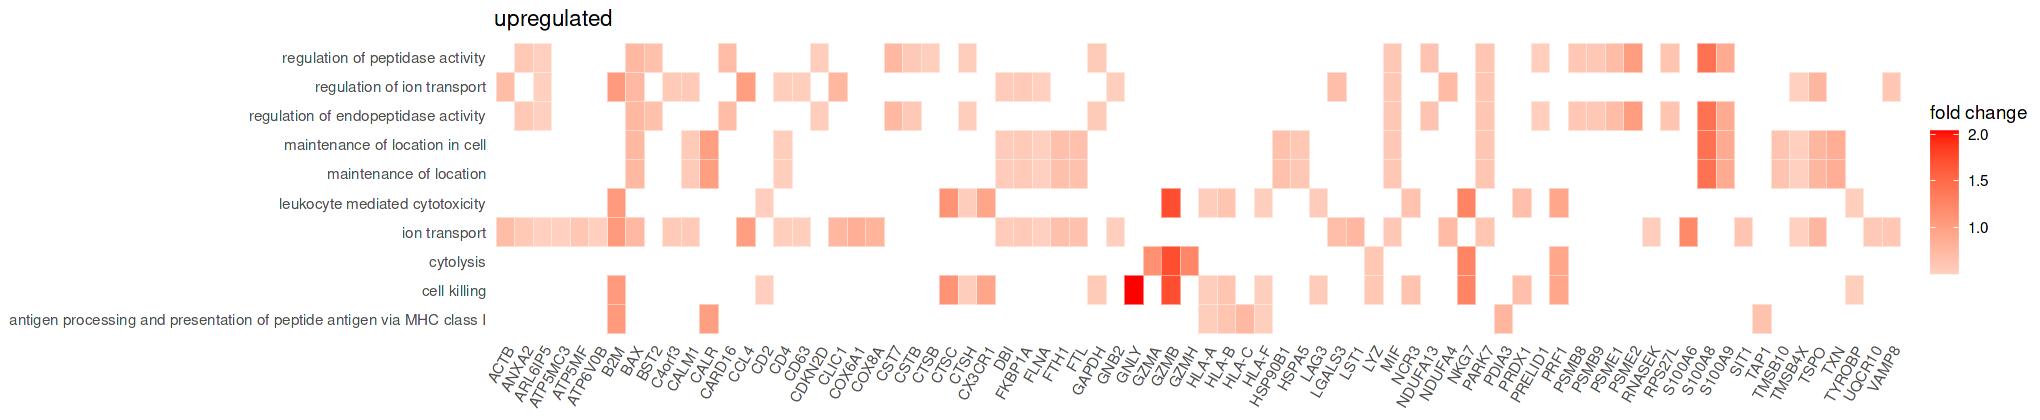

In [54]:
# Supp fig 4
options(repr.plot.width=17, repr.plot.height=3.5)
go_CARvspre_up[[2]]

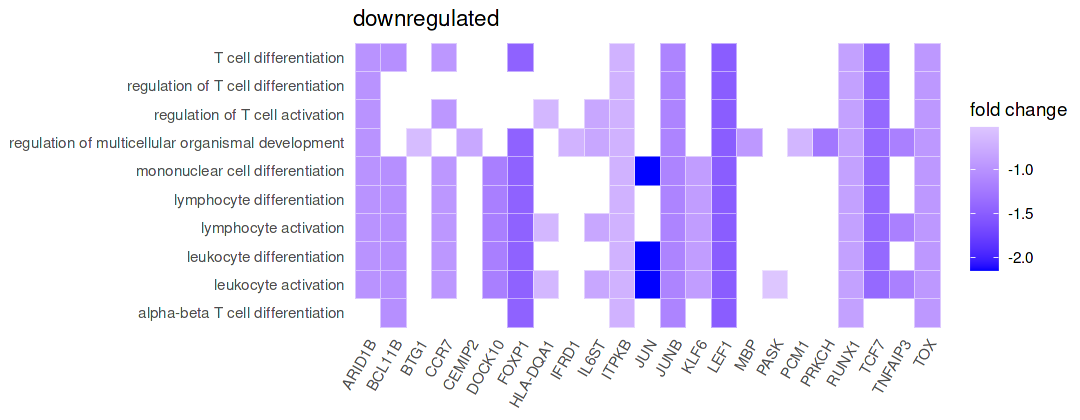

In [57]:
# Supp fig 4
options(repr.plot.width=9, repr.plot.height=3.5)
go_CARvspre_down[[2]]

In [14]:
#ADT
res_CARvspre_ADT=FindMarkers(seuratobj_full, ident.1='P14_85_30_PB_Tcells_TRUE', ident.2='P14_-1_-56_PB_Tcells_FALSE', group.by='condition', features=adttotest, logfc.threshold=0, assay='ADT')

In [15]:
adttoplot=res_CARvspre_ADT%>% filter(p_val_adj<0.05) %>% arrange(p_val_adj, -abs(avg_log2FC))  %>% slice_head(n=10) %>% rownames
mmtargets_plot=mmtargets_exp %>% filter(condition %in% c('P14_85_30_PB_Tcells_TRUE','P14_-1_-56_PB_Tcells_FALSE'), ADT %in% adttoplot)
mmtargets_plot$ADT=factor(mmtargets_plot$ADT, levels=str_sort(unique(mmtargets_plot$ADT), numeric=T))

In [16]:
mmtargets_plot=mmtargets_plot %>% mutate(condition=ifelse(condition=='P14_85_30_PB_Tcells_TRUE','CAR','Premanufacture'))

ADTs that are differentially expressed. 
Higher CD45RA expression indicates more naive phenotype in premanufacture T cells. Higher CD69 indicates more activation in premanufacture T cells. Higher CD279 in CAR indicates more exhaustion in CAR T. 

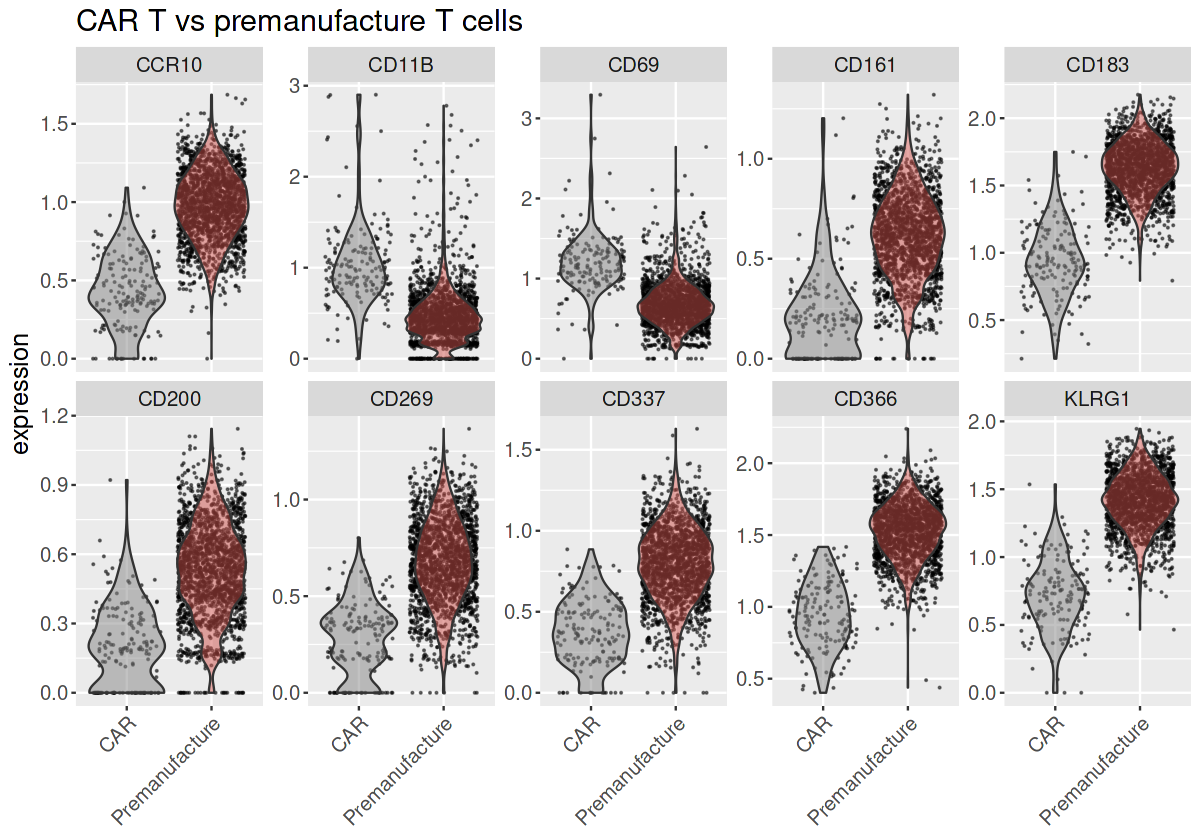

In [17]:
# Fgure 7E
options(repr.plot.width=10, repr.plot.height=7)
ggplot(mmtargets_plot, aes(fill=condition, y=expression, x=condition))+geom_jitter(size=0.1, alpha=0.5)+geom_violin(alpha=0.5)+
facet_wrap(~ADT, ncol=5, scales="free_y")+ theme(legend.position = "none")+
ggtitle('CAR T vs premanufacture T cells')+
 theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+ 
  theme(text = element_text(size = 15), axis.title.x=element_blank()) +
scale_fill_manual(values = pal_jco(palette = c("default"), alpha = 1)(n=4)[3:4])

## Patient 8 Cilta-cel CAR T cells

## Post infusion CAR T vs premanufacture T cells in PBMC
Here we compared P8\_103\_27\_PB CART cells to P8\_-6\_-82\_PB T cells. 

In [10]:
options(mc.cores=8)
res_CARvspre=FindMarkers(seuratobj_full, ident.1='P8_103_27_PB_Tcells_Ciltapos', ident.2='P8_-6_-82_PB_Tcells_Ciltaneg', group.by='condition', logfc.threshold=0,
                          test.use='MAST', latent.vars = 'WNN_agg')


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



In [15]:
res_CARvspre %>% rownames_to_column('genes') %>% write_csv('PostvsPre_P8.csv')

Results saved in PostvsPre_P8.csv

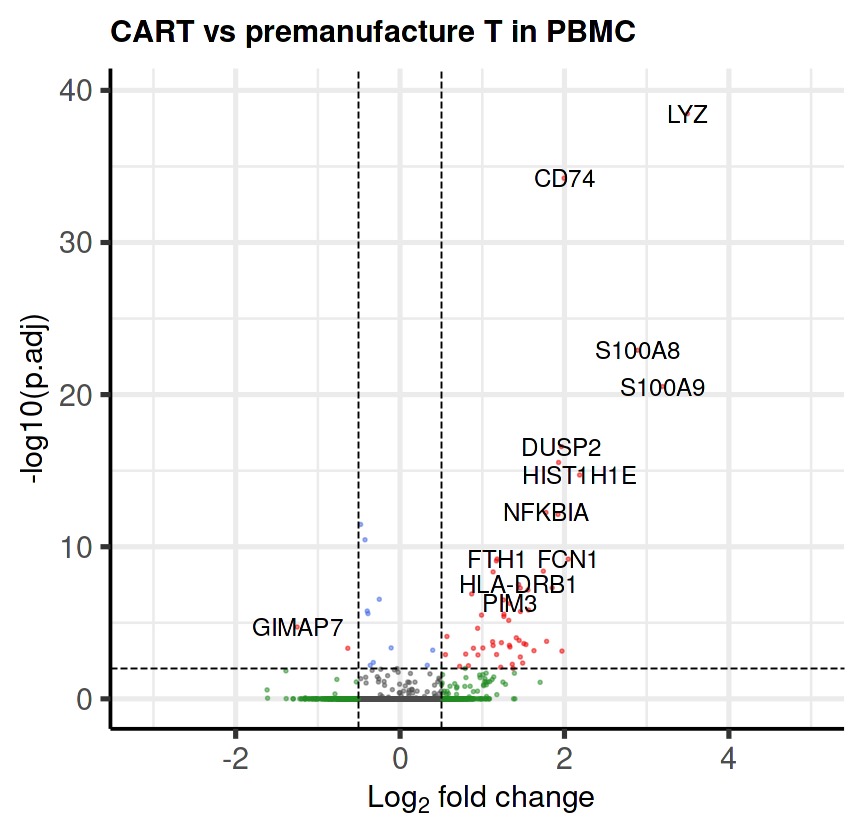

In [15]:
# Figure 7C
options(warn = -1)
res_CARvspre=res_CARvspre %>% mutate(p_val_adj=ifelse(p_val_adj==0, min( p_val_adj[p_val_adj!=min(p_val_adj)] ), p_val_adj)) %>%
filter(rownames(.)!='ciltacabtagene')
negsig=res_CARvspre %>% filter(avg_log2FC< -1, p_val_adj<0.01) %>% slice_min(p_val_adj, n=20) %>% rownames
possig=res_CARvspre %>% filter(avg_log2FC> 1,  p_val_adj<0.01) %>% slice_min(p_val_adj, n=20) %>% rownames
selectLab=c(negsig, possig)
p1=getvolcone_mast(res_CARvspre, title='CART vs premanufacture T in PBMC', connector = F, selectLab=selectLab)
options(repr.plot.width=7.2, repr.plot.height=7)
p1
options(warn = 0)

In [17]:
go_CARvspre_up=plotcnet_mast(res_CARvspre, direction='up')
go_CARvspre_down=plotcnet_mast(res_CARvspre, direction='down') # No hits

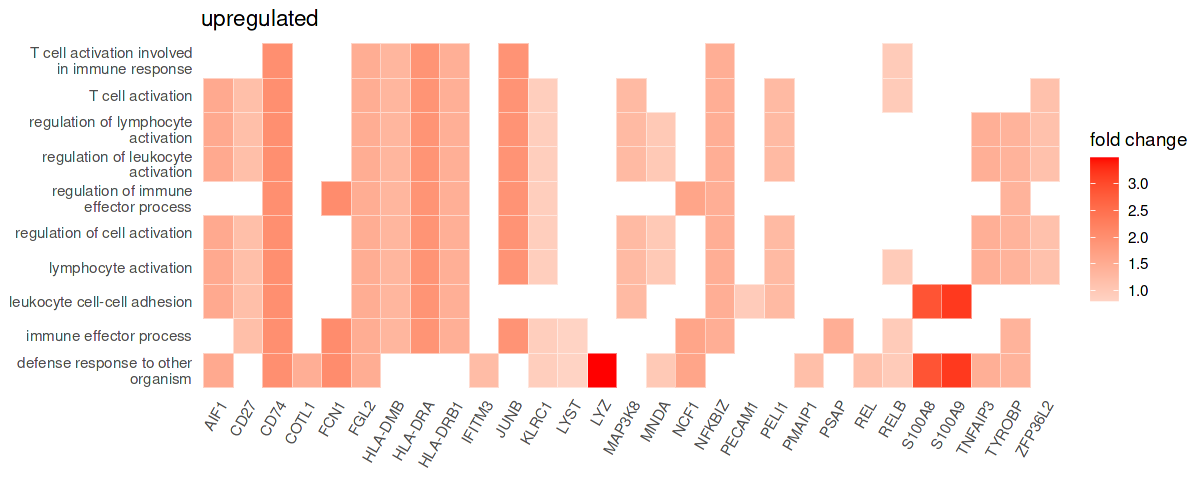

In [19]:
# Supp Fig 5
options(repr.plot.width=10, repr.plot.height=4)
go_CARvspre_up[[2]]

In [206]:
#ADT
adttotest=setdiff(rownames(seuratobj_full[['ADT']]), c('PE','FITC'))

In [68]:
res_CARvspre_ADT=FindMarkers(seuratobj_full, ident.1='P8_103_27_PB_Tcells_Ciltapos', ident.2='P8_-6_-82_PB_Tcells_Ciltaneg', group.by='condition', features=adttotest, logfc.threshold=0, assay='ADT')

In [69]:
adttoplot=res_CARvspre_ADT%>% filter(p_val_adj<0.05) %>% arrange(p_val_adj, -abs(avg_log2FC))  %>% slice_head(n=10) %>% rownames
mmtargets_plot=mmtargets_exp %>% filter(condition %in% c('P8_103_27_PB_Tcells_Ciltapos','P8_-6_-82_PB_Tcells_Ciltaneg'), ADT %in% adttoplot)
mmtargets_plot$ADT=factor(mmtargets_plot$ADT, levels=str_sort(unique(mmtargets_plot$ADT), numeric=T))

In [70]:
mmtargets_plot=mmtargets_plot %>% mutate(condition=ifelse(condition=='P8_103_27_PB_Tcells_Ciltapos','CAR','Premanufacture'))

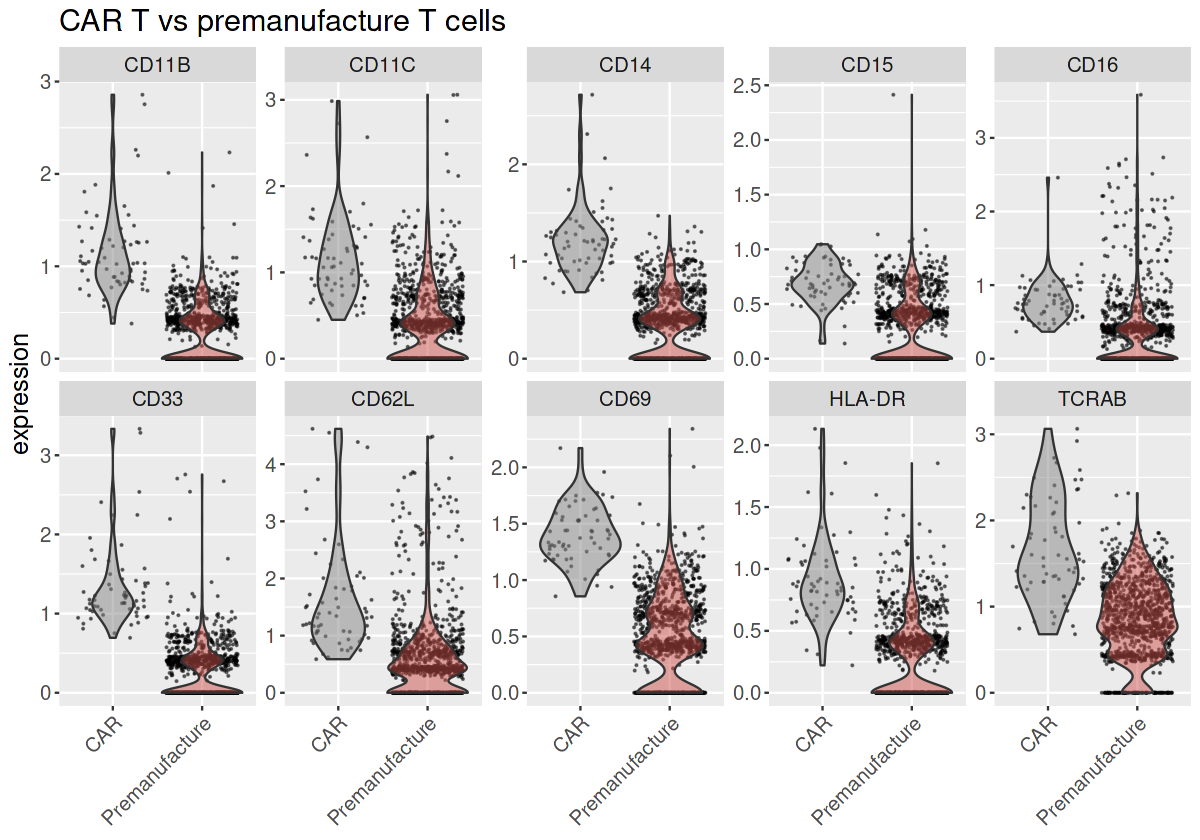

In [71]:
# Figure 7F
options(repr.plot.width=10, repr.plot.height=7)
ggplot(mmtargets_plot, aes(fill=condition, y=expression, x=condition))+geom_jitter(size=0.1, alpha=0.5)+geom_violin(alpha=0.5)+
facet_wrap(~ADT, ncol=5, scales="free_y")+ theme(legend.position = "none")+
ggtitle('CAR T vs premanufacture T cells')+
 theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+ theme(text = element_text(size = 15), axis.title.x=element_blank()) +
scale_fill_manual(values = pal_jco(palette = c("default"), alpha = 1)(n=4)[3:4])

## CAR T cells in BM vs CAR T in PBMC
Here we compare CARTs from P8\_103\_27\_BM to P8\_103\_27\_PB.

In [172]:
#ADT
res_CARBMvsPB_ADT=FindMarkers(seuratobj_full, ident.1='P8_103_27_BM_Tcells_Ciltapos', ident.2='P8_103_27_PB_Tcells_Ciltapos', group.by='condition', logfc.threshold=0,
                         assay='ADT')

In [181]:
adttoplot=res_CARBMvsPB_ADT%>% filter(p_val_adj<0.05) %>% arrange(p_val_adj, -abs(avg_log2FC))  %>% slice_head(n=10) %>% rownames
mmtargets_plot=mmtargets_exp %>% filter(condition %in% c('P8_103_27_BM_Tcells_Ciltapos','P8_103_27_PB_Tcells_Ciltapos'), ADT %in% adttoplot)

In [183]:
mmtargets_plot$ADT=factor(mmtargets_plot$ADT, levels=str_sort(unique(mmtargets_plot$ADT), numeric=T))

In [184]:
mmtargets_plot=mmtargets_plot %>% mutate(condition=ifelse(condition=='P8_103_27_BM_Tcells_Ciltapos','BM','PB'))

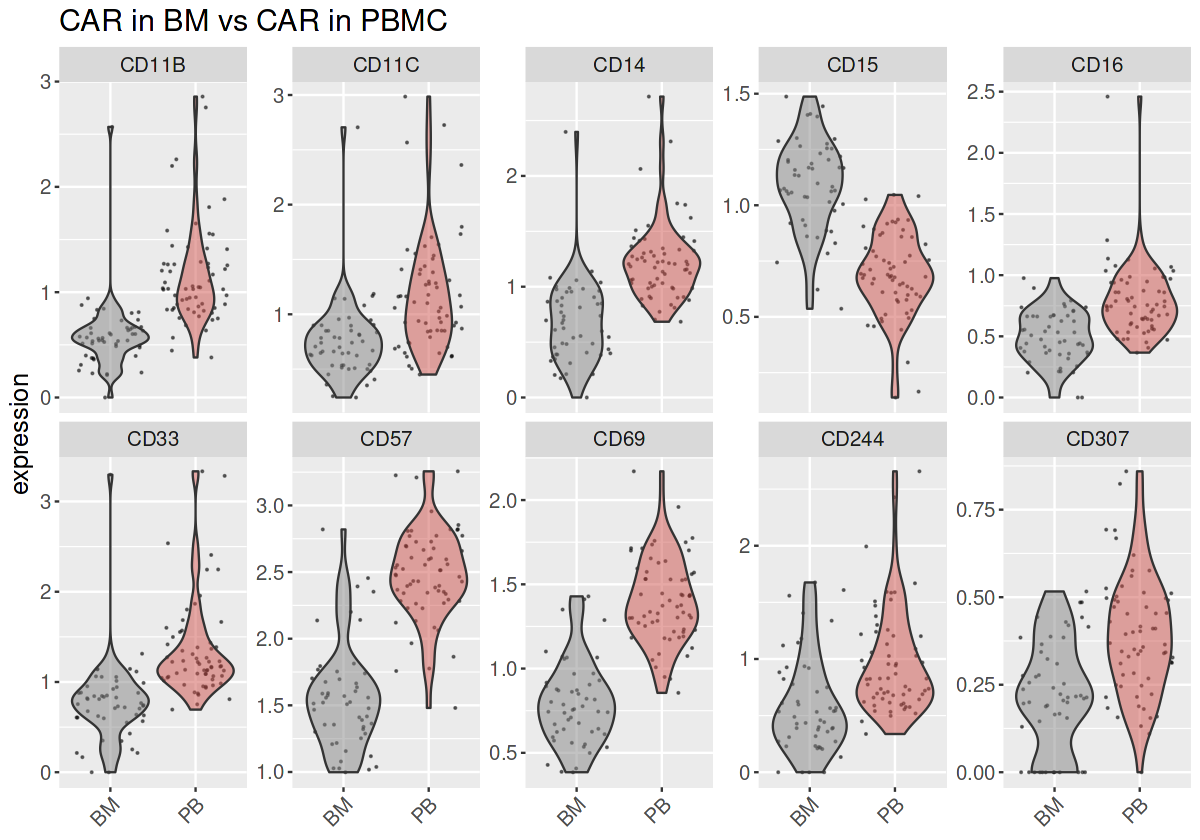

In [186]:
# Figure 7G
options(repr.plot.width=10, repr.plot.height=7)
ggplot(mmtargets_plot, aes(fill=condition, y=expression, x=condition))+geom_jitter(size=0.1, alpha=0.5)+geom_violin(alpha=0.5)+
facet_wrap(~ADT, ncol=5, scales="free_y")+ theme(legend.position = "none")+
ggtitle('CAR in BM vs CAR in PBMC')+
 theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+ 
  theme(text = element_text(size = 15), axis.title.x=element_blank()) +
scale_fill_manual(values = pal_jco(palette = c("default"), alpha = 1)(n=4)[3:4])